In [78]:
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Shortend collumn names

In [79]:
columns = [
    'Age_band', 'Edu_level', 'Sex_F', 'Sex_M', 'Relation_Employee',
    'Relation_Other', 'Relation_Owner', 'Exp_1_2yr', 'Exp_2_5yr', 'Exp_5_10yr',
    'Exp_10yr', 'Exp_1yr', 'Exp_No_Licence', 'Exp_Unknown', 'Lanes_Double_carriageway',
    'Lanes_One_way', 'Lanes_Two_way_broken', 'Lanes_Two_way_solid', 'Lanes_Undivided',
    'Lanes_other', 'Junction_Crossing', 'Junction_None', 'Junction_O_Shape', 'Junction_Other',
    'Junction_T_Shape', 'Junction_X_Shape', 'Junction_Y_Shape', 'Surface_Asphalt',
    'Surface_Asphalt_distress', 'Surface_Earth', 'Surface_Gravel', 'Surface_Other',
    'Light_Dark_lit', 'Light_Dark_unlit', 'Light_Dark_none', 'Light_Daylight',
    'Weather_Cloudy', 'Weather_Fog', 'Weather_Normal', 'Weather_Other', 'Weather_Rain',
    'Weather_Rain_Wind', 'Weather_Snow', 'Weather_Windy', 'Collision_Animal',
    'Collision_Pedestrian', 'Collision_Roadside_obj', 'Collision_Roadside_parked',
    'Collision_Fall', 'Collision_Other', 'Collision_Rollover', 'Collision_Vehicle',
    'Collision_Train', 'Movement_Entering_junction', 'Movement_Getting_off', 'Movement_Straight',
    'Movement_Backward', 'Movement_Other', 'Movement_Overtaking', 'Movement_Parked',
    'Movement_Reversing', 'Movement_Stopping', 'Movement_Turnover', 'Movement_U_Turn',
    'Movement_Waiting', 'Pedestrian_Cross_nearside', 'Pedestrian_Cross_nearside_masked',
    'Pedestrian_Cross_offside_masked', 'Pedestrian_Standing', 'Pedestrian_Standing_masked',
    'Pedestrian_None', 'Pedestrian_Unknown', 'Pedestrian_Walk_back_traffic', 'Pedestrian_Walk_facing_traffic',
    'Cause_Lane_left', 'Cause_Lane_right', 'Cause_High_speed', 'Cause_Careless', 'Cause_Left',
    'Cause_Drugs', 'Cause_Drunk', 'Cause_Improper_getting_off', 'Cause_Improper_parking',
    'Cause_Backward', 'Cause_No_distancing', 'Cause_No_priority_pedestrian', 'Cause_No_priority_vehicle',
    'Cause_Other', 'Cause_Overloading', 'Cause_Overspeed', 'Cause_Overtaking', 'Cause_Overturning',
    'Cause_Turnover'
]

# Load the data and transform it for binary logistic regression

In [80]:
data_train = pd.read_csv("../data/interim/oversampled_train.csv")
data_test = pd.read_csv('../data/interim/oversampled_test.csv')

In [81]:
X_train = data_train.drop(columns='Accident_severity')
y_train = data_train.Accident_severity
X_train.columns = columns

X_test = data_test.drop(columns='Accident_severity')
y_test = data_test.Accident_severity
X_test.columns = columns

y_train_reg = y_train.replace(2, 1)
y_test_reg = y_test.replace(2, 1)

In [82]:
y_train_reg.replace({0: 1, 1: 0}, inplace=True)
y_test_reg.replace({0: 1, 1: 0}, inplace=True) 

In [83]:
X_train_scaled_with_const = sm.add_constant(X_train)
smf_data = pd.concat([X_train_scaled_with_const, y_train_reg], axis = 1)

# Create the Logistic Regression

In [84]:
# Create the formula
formula = "Accident_severity ~ I(Lanes_Undivided) + I(Junction_None) + I(Cause_Backward) + I(Light_Dark_lit) + I(Junction_Crossing) + \
I(Exp_2_5yr) + I(Exp_1yr)"


# Fit the model
model = logit(formula=formula, data=smf_data)
result = model.fit()

# Print the summary report
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.283287
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      Accident_severity   No. Observations:                 6678
Model:                          Logit   Df Residuals:                     6670
Method:                           MLE   Df Model:                            7
Date:                Wed, 19 Jun 2024   Pseudo R-squ.:                 0.07313
Time:                        14:56:14   Log-Likelihood:                -1891.8
converged:                       True   LL-Null:                       -2041.1
Covariance Type:            nonrobust   LLR p-value:                 1.250e-60
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.9349      0.091    -32.128      0.000      -3.114      -2.756

# Analysis for Marginal Effects and OR

In [85]:
marginal_effects = result.get_margeff(at='overall', method='dydx')
AME = marginal_effects.margeff

In [86]:
marginal_effects.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:      Accident_severity
Method:                          dydx
At:                           overall
========================================================================================
                          dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
I(Lanes_Undivided)       0.0467      0.007      6.679      0.000       0.033       0.060
I(Junction_None)         0.0335      0.007      4.671      0.000       0.019       0.047
I(Cause_Backward)        0.0851      0.009      9.497      0.000       0.068       0.103
I(Light_Dark_lit)        0.0494      0.007      6.830      0.000       0.035       0.064
I(Junction_Crossing)    -0.0902      0.014     -6.517      0.000      -0.117      -0.063
I(Exp_2_5yr)             0.0239      0.008      3.126      0.002       0.009       0.039
I(Exp_1yr)              -0.0584      0.015     -3.854      0.000      -0.088      -0.029
========================================================================================
"""

In [87]:
AME_zero = np.insert(AME, 0, 0)

## OR Analysis

In [88]:
odds_ratios = {}
probabilities = {}
for i, key in enumerate(result.params.keys()):
    value = result.params[key]
    AME = AME_zero [i]
    
    # Exponentiate the coefficient to get the odds ratio
    odds_ratio = np.exp(value)
    odds_ratios[key] = odds_ratio
    probabilities[key] = AME 

In [89]:
# Extract feature names and probability values and sort by probability values English
sorted_features_or = sorted(odds_ratios, key=odds_ratios.get)
sorted_values_or = [odds_ratios[key] for key in sorted_features_or]

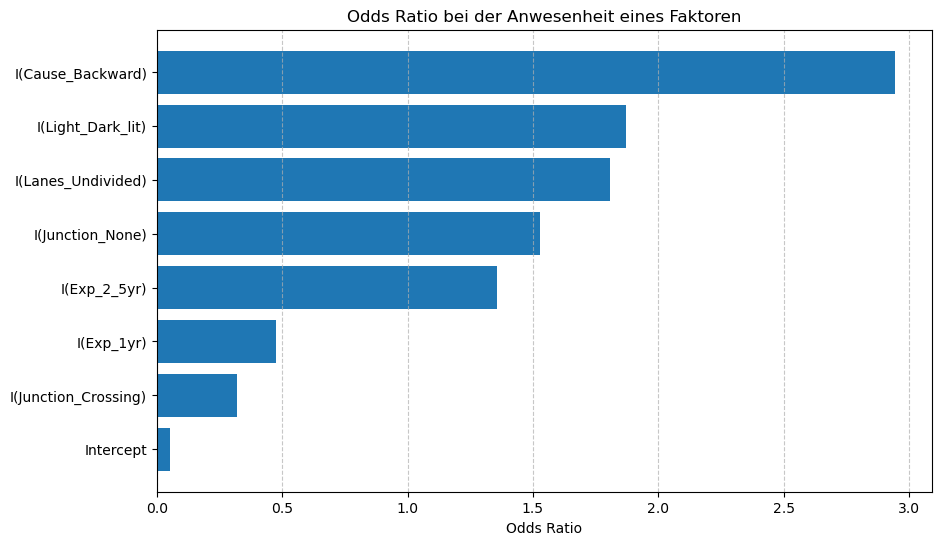

In [90]:
# Create plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_or, sorted_values_or)
plt.xlabel('Odds Ratio')
plt.title('Odds Ratio bei der Anwesenheit eines Faktoren')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

## AME Analysis

In [91]:
# Extract feature names and probability values and sort by probability values
sorted_features_pr = sorted(probabilities, key=probabilities.get)
sorted_values_pr = [probabilities[key] for key in sorted_features_pr]

In [92]:
sorted_features_pr.pop(2) 
sorted_values_pr.pop(2)

0.0

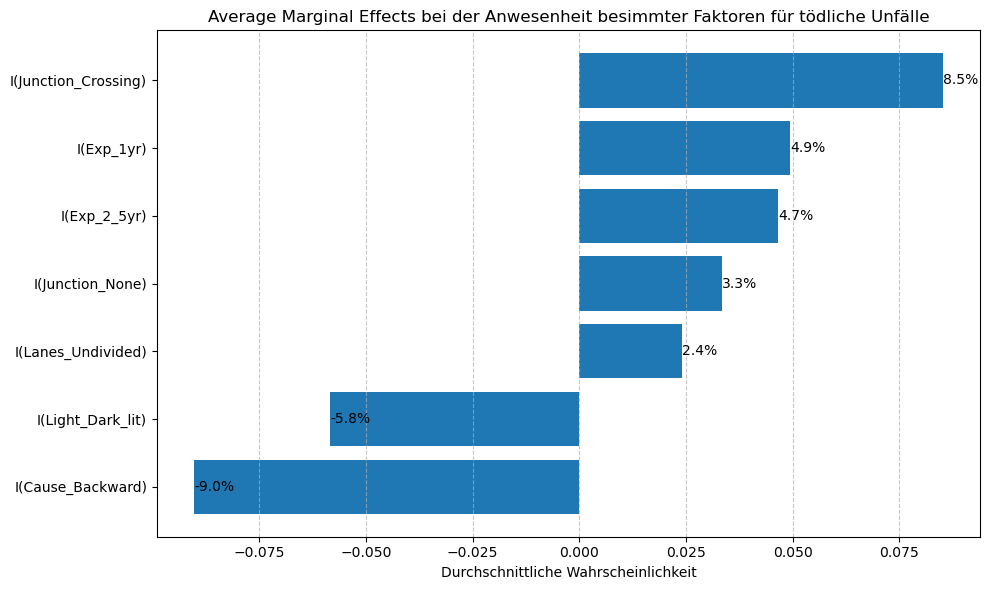

In [93]:
# Plot erstellen
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_features_pr[::-1], sorted_values_pr)

plt.xlabel('Durchschnittliche Wahrscheinlichkeit')
plt.title('Average Marginal Effects bei der Anwesenheit besimmter Faktoren für tödliche Unfälle')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adding percentages to the bars
for bar, percentage in zip(bars, sorted_values_pr):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{percentage*100:.1f}%', 
             va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [94]:
sorted_values_pr

[-0.0902326874699488,
 -0.05844731791612168,
 0.023941959074822595,
 0.0334524341535197,
 0.046664030872539335,
 0.04941055831117545,
 0.08510878668966702]